# Importance Sampling
Suppose we are interested in approximating $\mathbb{P}(X>25)$ for the random variable $X\sim {\chi_3}^2$. 

$$
  \mathbb{P}(X>25) = \int_{25}^{\infty}f_X(x)dx, \qquad \text{where }f_X \text{ is the pdf for }X.
$$

We can approximate it by sampling ${\chi_3}^2$ and looking at how often we get a value greater than 25. However that would require a large number of samples due to the fact that X>25 is a very rare event for ${\chi_3}^2$. For examples if we draw 100,000 samples, we get the following:

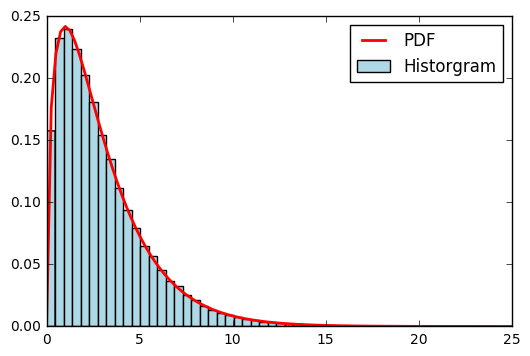

From 100000 draws, a total of 0 were greater than 25.
  The approximate value of the probability is: 0.000e+00
  The true value of the probability is: 1.544e-05


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import pandas as pd

np.random.seed(177) # For a consistant examples

nDraws = 100000
X = ss.chi2(df=3)
draws = X.rvs(nDraws)
trueProb = 1 - X.cdf(25)

plt.close(1); plt.figure(1)
plt.hist(draws, bins=50, normed=True, color="lightblue", label="Historgram")
plt.plot(np.linspace(0,25,100), X.pdf(np.linspace(0,25,100)), "-r", lw = 2, label="PDF")
plt.legend(loc="best")
plt.show()

print("""From {:d} draws, a total of {:d} were greater than 25.
  The approximate value of the probability is: {:0.3e}
  The true value of the probability is: {:0.3e}""" \
      .format(nDraws, draws[draws>25].shape[0], (draws>25).mean(),trueProb))

So right away, we can see that 100,000 draws isn't enough to approximate the probability since none of the values are greater than 25 and therefore, the approximation would be 0. But the ${\chi_3}^2$ pdf is non-zero out until infinity, so we know it possible. 

As a matter of fact, if we draw 1 million draws (using the same seed) we get 14 of those draws above 25, which gives $1.400\times10^{-5}$, where the correct value is closer to $1.544\times10^{-5}$.

In [2]:
np.random.seed(177) # For a consistant examples
nDraws = 1000000
draws = X.rvs(nDraws)

approxProb = (draws>25).mean()

print("""From {:d} draws, a total of {:d} were greater than 25.
  The approximate value of the probability is: {:0.3e}
  The true value of the probability is: {:0.3e}""" \
      .format(nDraws, draws[draws>25].shape[0], (draws>25).mean(),trueProb))

From 1000000 draws, a total of 14 were greater than 25.
  The approximate value of the probability is: 1.400e-05
  The true value of the probability is: 1.544e-05


So we get closer with 1 million draws, but it's still not a great approximation. One way around this problem is to use importance sampling. The idea is similar to [Monte Carlo integration](https://github.com/AbeNassar/Playground/blob/master/Simulations/Monte%20Carlo%20Integration.ipynb) but we choose another random variable $Y$

\begin{align*}
    \mathbb{P}(X>25) &= \int_{25}^{\infty}f_X(x)dx
\end{align*}

To do this, we need a distribution we can sample with the same support. Then we can write 

\begin{align*}
    \mathbb{P}(X>25) 
      &= \int_{25}^{\infty}f_X(x)dx = \int_{25}^{\infty} \frac{f_X(x)}{f_Y(x)} f_Y(x)dx 
\end{align*}

And using Monte Carlo integration, this becomes 


\begin{align*}
    \mathbb{P}(X>25) 
      &= \int_{25}^{\infty} \frac{f_X(x)}{f_Y(x)} f_Y(x)dx \\
      &\approx \frac{1}{n} \sum_{\forall i} \frac{f_X(x_i)}{f_Y(x_i)}, 
          \qquad\text{where }x_i\text{ is drawn from }Y.
\end{align*}


In this case, we can choose an exponential truncated at 25. The great thing about the exponetial distribution is it's memorylessness property, which implies that truncating the probability at 25 is the same as translating by 25. This makes the calculation even easier because we can sample the normal exponential distribution and shift those values by subtracting 25.

In [3]:
def importanceSampling(function, Y_distribution, nSamples):
    """Uses Importance Sampling int approximate an integral of function
    INPUT
      function: function to be integrated.
      Y_distribution: SciPy distribution, used to calculate importance weights and 
                      draw samples from. All drawn samples must be in domain of `function`
      nSamples: int, number of samples to draw
    OUTPUT
      float, approximation of the integral of `function` over support of Y_distribution.
    """
    # Define importance weights. The ratios of the PDFs.
    importance = lambda x: function(x)/Y_distribution.pdf(x)

    # Sample from Y distribution
    Xi = Y_distribution.rvs(nSamples)
    
    return np.apply_along_axis(importance, 0, Xi).mean()

# Numbers of simulations
nSims = 1000

# Define X and Y distributions
X = lambda x: ss.chi2(3).pdf(x)
Y = ss.expon(loc=25) #loc=25 corresponds to subtracting 25.

# calculate importance weights
approxProb = importanceSampling(X, Y, nSims)

print("""From {:d} draws, using importance sampling
  The approximate value of the probability is: {:0.3e}
  The true value of the probability is: {:0.3e}""" \
      .format(nSims, approxProb, trueProb))

From 1000 draws, using importance sampling
  The approximate value of the probability is: 1.513e-05
  The true value of the probability is: 1.544e-05


So we can see that in this example importance sampling gave a significantly better approximation using only 1,000 draws, which is 1,000 times fewer draws compared to the previous example.

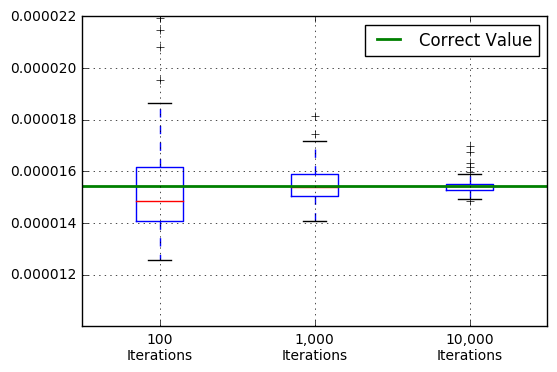

In [4]:
x100 = np.repeat(100,100)
x1k  = np.repeat(1000,100)
x10k = np.repeat(10000,100)

boxPlotData = pd.DataFrame({"I100":x100, "I1000":x1k, "I10000":x10k})
sim = lambda nSim: importanceSampling(X, Y, nSim)

boxPlotData = boxPlotData.applymap(sim)
boxPlotData.boxplot()
plt.axhline(trueProb, color="green", label="Correct Value", lw=2)
plt.legend(loc="upper right")
plt.ylim(1e-5, 2.2e-5)
plt.xticks([1, 2, 3], ["100\nIterations", "1,000\nIterations", "10,000\nIterations"])
plt.show()

So we can see that the variance decreases as the number of iterations decrease. And 10,000 gives a very good approximation, where 1,000,000 samples were neeeded to get a relatively bad approximation using regular Monte Carlo integration. 